<a href="https://colab.research.google.com/github/vijaygwu/MathematicsOfML/blob/main/Skip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Understanding How Gradients Change with Skip Connections in Neural Networks**

Skip connections, introduced in architectures like ResNet, have revolutionized deep learning by mitigating the vanishing gradient problem. This explanation will delve into how gradients propagate in neural networks **before and after** introducing skip connections, supported by example code and illustrative diagrams.

---

### **1. The Vanishing Gradient Problem in Deep Networks**

In deep neural networks without skip connections, gradients tend to diminish as they are backpropagated through each layer. This makes it challenging for the early layers to learn effectively because the updates to the weights become negligible.

**Simple Neural Network Without Skip Connections:**

```python
import torch
import torch.nn as nn
import torch.nn.functional as F

class PlainBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PlainBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        return out
```

**Gradient Flow Without Skip Connections:**

When backpropagating, the gradient `∂L/∂x` (where `L` is the loss) diminishes with each layer due to the chain rule:

\[
\frac{\partial L}{\partial x} = \frac{\partial L}{\partial y} \cdot \frac{\partial y}{\partial x}
\]

As we go deeper, the multiplication of small gradients leads to an exponentially smaller gradient at the earlier layers.

---

### **2. Introducing Skip Connections**

Skip connections allow gradients to bypass certain layers, providing a direct path for gradient flow and alleviating the vanishing gradient problem.

**Residual Block with Skip Connections:**

```python
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.skip_connection = nn.Identity()

        if in_channels != out_channels:
            self.skip_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        identity = self.skip_connection(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity  # Skip connection adds the input to the output
        out = self.relu(out)
        return out
```

**Improved Gradient Flow with Skip Connections:**

With skip connections, the gradient at earlier layers receives contributions directly from the loss, bypassing the chain of small gradients:

$
\frac{\partial L}{\partial x} = \frac{\partial L}{\partial y} + \text{gradient via skip connection}
\ $

This additive term helps maintain a stronger gradient signal during backpropagation.

---

### **3. Comparing Gradients: An Example**

Let's create a deep network composed of multiple layers and compare the gradient magnitudes with and without skip connections.

**Code to Compare Gradient Magnitudes:**

```python
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Define a function to compute gradients
def compute_gradients(model, input_tensor, target):
    criterion = nn.MSELoss()
    output = model(input_tensor)
    loss = criterion(output, target)
    loss.backward()
    gradients = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            gradients.append(param.grad.abs().mean().item())
    model.zero_grad()
    return gradients

# Create models
plain_model = nn.Sequential(*[PlainBlock(64, 64) for _ in range(10)])
residual_model = nn.Sequential(*[ResidualBlock(64, 64) for _ in range(10)])

# Input and target tensors
input_tensor = torch.randn(1, 64, 32, 32, requires_grad=True)
target = torch.randn(1, 64, 32, 32)

# Compute gradients
plain_gradients = compute_gradients(plain_model, input_tensor, target)
residual_gradients = compute_gradients(residual_model, input_tensor, target)

```

**Explanation:**

- **compute_gradients:** This function runs a forward and backward pass, recording the average gradient magnitude for each layer.
- **plain_model and residual_model:** Both models have 10 layers, one without skip connections and one with.
- **Plotting:** We plot the average gradient magnitude per layer to visualize the differences.

**Expected Results:**

- **Plain Network:** Gradients diminish rapidly in earlier layers.
- **Residual Network:** Gradients remain relatively larger in earlier layers due to skip connections.

---

### **4. Diagram Illustrating Gradient Flow**

#### **Without Skip Connections:**

```
Input ---> [Layer 1] ---> [Layer 2] ---> ... ---> [Layer N] ---> Output
             ↓             ↓                    ↓
          Gradients    Gradients             Gradients
         (vanishing)  (more vanishing)     (even more vanishing)
```

- **Gradient Path:** Single path through all layers.
- **Vanishing Effect:** Gradient magnitudes decrease exponentially with depth.

#### **With Skip Connections:**

```
          +---------------------------------------------+
          |                                             |
Input --->| [Layer 1] ---> [Layer 2] ---> ... ---> [Layer N] |---> Output
          |       |             |                    |      |
          +-------+-------------+--------------------+------+
                   \             \                    \
                Skip Connection Skip Connection    Skip Connection
                      ↓             ↓                    ↓
                  Gradients      Gradients           Gradients
                  (preserved)    (preserved)         (preserved)
```

- **Gradient Paths:** Multiple paths due to skip connections.
- **Preserved Gradients:** Direct paths help maintain gradient magnitudes.

---

### **5. Mathematical Explanation**

**Without Skip Connections:**

In a deep network, the gradient of the loss `L` with respect to parameters in layer `k` is:

$
\frac{\partial L}{\partial W_k} = \left( \prod_{i=k+1}^{N} \frac{\partial h_i}{\partial h_{i-1}} \right) \frac{\partial L}{\partial h_N}
$

- **Product of Derivatives:** Small derivatives less than 1 lead to vanishing gradients.

**With Skip Connections:**

Skip connections introduce additive terms in the gradient computation:



$
\frac{\partial L}{\partial W_k} = \frac{\partial L}{\partial h_k} + \frac{\partial L}{\partial h_{k+1}} \cdot \frac{\partial h_{k+1}}{\partial h_k}
$



- **Additive Gradients:** The direct gradient `∂L/∂h_k` helps prevent vanishing.

---

### **6. Benefits of Skip Connections**

- **Mitigate Vanishing Gradients:** By providing alternative paths for gradients.
- **Enable Deeper Networks:** Allow training of networks with hundreds or thousands of layers.
- **Improve Performance:** Often lead to better accuracy and faster convergence.

---




In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    """
    This class defines a residual block with skip connections.
    Skip connections help in training deep neural networks by
    allowing gradients to flow directly through the network.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        stride (int): Stride for the convolutional layers. Default is 1.
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        # Batch normalization layer
        self.bn1 = nn.BatchNorm2d(out_channels)
        # Activation function
        self.relu = nn.ReLU(inplace=True)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        # Batch normalization layer
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Downsample layer to match dimensions (if needed)
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = None

    def forward(self, x):
        # Save the input tensor to add later (skip connection)
        identity = x

        # First layer operations
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Second layer operations
        out = self.conv2(out)
        out = self.bn2(out)

        # Adjust the input (identity) if dimensions have changed
        if self.downsample is not None:
            identity = self.downsample(x)

        # Add skip connection (the identity)
        out += identity
        out = self.relu(out)

        return out

# Example usage:
if __name__ == '__main__':
    # Create a Residual Block with dimension change
    in_channels = 64
    out_channels = 128
    stride = 2  # This will reduce the spatial dimensions
    block = ResidualBlock(in_channels, out_channels, stride)

    # Create a dummy input tensor (e.g., a batch of images)
    x = torch.randn(1, in_channels, 56, 56)  # Batch size 1, 64 channels, 56x56 image

    # Pass the input through the residual block
    y = block(x)
    print(y.shape)  # Outputs: torch.Size([1, 128, 28, 28]) due to stride=2


torch.Size([1, 128, 28, 28])


In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.skip_connection = nn.Identity()

        if in_channels != out_channels:
            self.skip_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        identity = self.skip_connection(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity  # Skip connection adds the input to the output
        out = self.relu(out)
        return out


**Identity and residual connections**

In this code, the concept of the "identity" plays a crucial role in implementing **residual connections** within a `ResidualBlock`. Let’s break down its significance:

1. **Role of Identity in Residual Blocks**:
   - In residual networks, each block attempts to learn a residual mapping, meaning it learns the difference (or residual) between the input (`identity`) and the output after passing through the block.
   - The idea is that, instead of learning a completely new transformation, the network only needs to learn the "adjustment" to the input. This is the foundation of skip connections.
   - Mathematically, if the input is `x` and the transformation through the block is `F(x)`, then the output of the block becomes `F(x) + x`. This addition (`+ x`) is the "identity" operation, which helps preserve information from earlier layers, making gradient flow easier and preventing the vanishing gradient problem in deep networks.

2. **Identity Matrix in Code**:
   - In the code, `identity = x` captures the input tensor `x` before applying any transformations. This is the "identity" that will be added back to the output of the transformations inside the block.
   - If the spatial dimensions or number of channels of `x` change (for example, due to the stride of the convolutional layer), the `downsample` layer adjusts `identity` to match the shape of the transformed output (`out`). This ensures that `identity` and `out` are compatible for element-wise addition.

3. **When Downsampling Occurs**:
   - If `stride != 1` or the number of `in_channels` differs from `out_channels`, a 1x1 convolution (in `downsample`) is used to transform `identity` to match the dimensions of `out`.
   - Otherwise, if dimensions are already aligned, `downsample` is skipped, and `identity` remains unchanged, allowing for a straightforward addition.

4. **SPurpose**:
   - By adding `identity` (the original input) to the output `out`, this design allows each residual block to focus on learning small changes or refinements, rather than an entirely new transformation. This simplifies the learning process for deeper layers, allowing them to "skip" parts of the transformation if needed, making it easier for gradients to flow backward.

In summary, the "identity" here refers to the unmodified input of each residual block, which is added back to the transformed output to improve gradient flow and alleviate training challenges in deep networks.

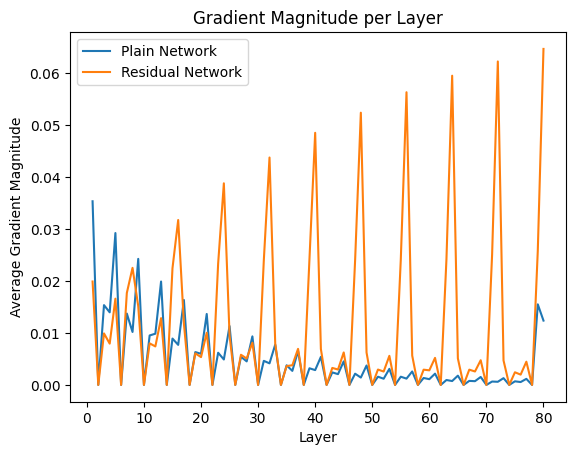

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Define the PlainBlock class
class PlainBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PlainBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        return out

# Define the ResidualBlock class
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.skip_connection = nn.Identity()

        if in_channels != out_channels:
            self.skip_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        identity = self.skip_connection(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity  # Skip connection adds the input to the output
        out = self.relu(out)
        return out

# Define a function to compute gradients
def compute_gradients(model, input_tensor, target):
    criterion = nn.MSELoss()
    output = model(input_tensor)
    loss = criterion(output, target)
    loss.backward()
    gradients = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            gradients.append(param.grad.abs().mean().item())
    model.zero_grad()
    return gradients

# Create models
plain_model = nn.Sequential(*[PlainBlock(64, 64) for _ in range(10)])
residual_model = nn.Sequential(*[ResidualBlock(64, 64) for _ in range(10)])

# Input and target tensors
input_tensor = torch.randn(1, 64, 32, 32, requires_grad=True)
target = torch.randn(1, 64, 32, 32)

# Compute gradients
plain_gradients = compute_gradients(plain_model, input_tensor, target)
residual_gradients = compute_gradients(residual_model, input_tensor, target)

# Plotting the gradients
layers = range(1, len(plain_gradients) + 1)
plt.plot(layers, plain_gradients, label='Plain Network')
plt.plot(layers, residual_gradients, label='Residual Network')
plt.xlabel('Layer')
plt.ylabel('Average Gradient Magnitude')
plt.title('Gradient Magnitude per Layer')
plt.legend()
plt.show()


This plot compares the average gradient magnitude per layer between a "Plain Network" (blue line) and a "Residual Network" (orange line) over 80 layers. The y-axis shows the average gradient magnitude, while the x-axis indicates the layer number.

1. **Plain Network vs. Residual Network**: The "Plain Network" (without skip connections) has a more stable but lower gradient magnitude across layers, which could indicate that it suffers from vanishing gradients, especially in deeper layers.

2. **Residual Network Behavior**: The "Residual Network" (with skip connections) has periodic spikes in gradient magnitude at certain layers. These peaks indicate that gradients are preserved better across layers in the residual network, which helps prevent the vanishing gradient problem.

3. **Significance of Gradient Magnitude**: High gradient magnitudes, as seen in the residual network, facilitate better weight updates during backpropagation, especially in deep networks. The skip connections in the residual network allow gradients to flow more effectively through the network, enhancing learning efficiency in deeper architectures.

4. **Spikes** The periodic spikes in the residual network's gradient might correspond to specific layer types (e.g., residual blocks), where gradient flow is more prominent due to the skip connections.

